# SVM: Version 7

## SVM with PCA (HSV)

In [1]:
import cv2
import os
import glob
import time
import mlflow
import random
import shutil
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

In [2]:
TRAIN_DIR = "../data/train"
CLASS_FOLDERS = ["Class A", "Class B", "Class C", "Class D"]
ML_FLOW_DIRECTORY = "SVM_Logs"

In [3]:
mlflow.set_tracking_uri(ML_FLOW_DIRECTORY)
mlflow.set_experiment("SVM_PCA_HSV")

<Experiment: artifact_location='/Users/jacob/Code/Monkey-Business/SVM/SVM_Logs/989449714590752736', creation_time=1701991570925, experiment_id='989449714590752736', last_update_time=1701991570925, lifecycle_stage='active', name='SVM_PCA_HSV', tags={}>

In [4]:
pca_components = [40 * 40, 45 * 45, 50 * 50]
C_values = [0.1, 1, 10]
kernel_types = ["linear", "rbf"]
gamma_values = ["scale", "auto"]

In [5]:
hyperparameter_combinations = list(
    itertools.product(pca_components, C_values, kernel_types, gamma_values)
)
print(
    f"Total number of hyperparameter combinations: {len(hyperparameter_combinations)}"
)

Total number of hyperparameter combinations: 36


In [6]:
pca_models_dict = {}

In [7]:
def train_with_params(pca_components, C, kernel, gamma, train_images, train_labels):
    # Check if PCA model for pca_components already exists
    if pca_components in pca_models_dict:
        pca = pca_models_dict[pca_components]
        print(f"Using existing PCA model for {pca_components} components")
    else:
        # Apply PCA
        pca = PCA(n_components=pca_components)
        pca.fit(train_images)
        pca_models_dict[pca_components] = pca

    # Transform images with PCA
    train_images_pca = pca.transform(train_images)

    with mlflow.start_run() as run:
        start_time = time.time()

        # Initialize SVM model
        svm_model = svm.SVC(
            C=C, kernel=kernel, gamma=gamma, class_weight="balanced", verbose=True
        )

        # Perform cross-validation
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scoring = {
            "f1_weighted": make_scorer(f1_score, average="weighted"),
            "accuracy": "accuracy",
            "precision": make_scorer(precision_score, average="weighted"),
            "recall": make_scorer(recall_score, average="weighted"),
        }
        cv_results = cross_validate(
            svm_model,
            train_images_pca,
            train_labels,
            cv=skf,
            scoring=scoring,
            verbose=2,
        )

        # Log hyperparameters and metrics
        mlflow.log_params(
            {"pca_components": pca_components, "C": C, "kernel": kernel, "gamma": gamma}
        )
        mlflow.log_metrics(
            {
                "mean_f1_weighted": cv_results["test_f1_weighted"].mean(),
                "mean_accuracy": cv_results["test_accuracy"].mean(),
                "mean_precision": cv_results["test_precision"].mean(),
                "mean_recall": cv_results["test_recall"].mean(),
            }
        )
        end_time = time.time()
        duration = end_time - start_time
        param_details = f"PCA={pca_components}, C={C}, kernel={kernel}, gamma={gamma}"
        duration_details = f"Training duration for {param_details}: {duration} seconds"
        print(duration_details)
        run_id = run.info.run_id
        return run_id

In [8]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_folder in CLASS_FOLDERS:
        start_time = time.time()
        class_path = os.path.join(folder, class_folder)
        image_files = glob.glob(os.path.join(class_path, "*.png"))
        for img_file in image_files:
            processed_image = cv2.imread(img_file)
            hsv_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2HSV)  # Convert to HSV
            flattened_image = hsv_image.flatten()
            images.append(flattened_image)
            labels.append(class_folder)
        end_time = time.time()
        duration = end_time - start_time
        print(f"Processing {class_folder} took {duration} seconds")
    return np.array(images), np.array(labels)

In [9]:
train_images, train_labels = load_images_from_folder(TRAIN_DIR)

Processing Class A took 1.5252327919006348 seconds
Processing Class B took 0.8888120651245117 seconds
Processing Class C took 0.6818699836730957 seconds
Processing Class D took 0.8278677463531494 seconds


In [10]:
print(
    f"Shape of train_images: {train_images.shape}, Shape of train_labels: {train_labels.shape}"
)

Shape of train_images: (2796, 150528), Shape of train_labels: (2796,)


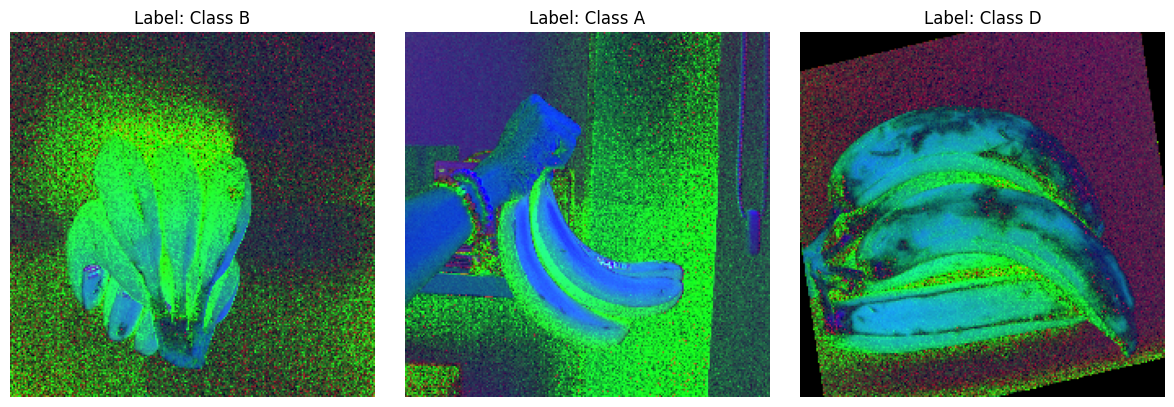

In [11]:
random_indices = random.sample(range(len(train_images)), 3)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, idx in enumerate(random_indices):
    image = train_images[idx].reshape(
        224, 224, 3
    )
    label = train_labels[idx]

    axs[i].imshow(image)
    axs[i].set_title(f"Label: {label}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [12]:
run_ids = []

for params in hyperparameter_combinations:
    pca_components, C, kernel, gamma = params
    run_id = train_with_params(pca_components, C, kernel, gamma, train_images, train_labels)
    run_ids.append(run_id)

[LibSVM].....*..*
optimization finished, #iter = 7492
obj = -0.000005, rho = 0.278991
nSV = 511, nBSV = 0
.*
optimization finished, #iter = 1647
obj = -0.000001, rho = -0.557537
nSV = 242, nBSV = 0
.*.*
optimization finished, #iter = 2234
obj = -0.000001, rho = -0.485914
nSV = 299, nBSV = 0
....*..*
optimization finished, #iter = 4472
obj = -0.000014, rho = -2.805781
nSV = 310, nBSV = 0
...*..*
optimization finished, #iter = 4108
obj = -0.000002, rho = -0.987301
nSV = 420, nBSV = 0
..*.*
optimization finished, #iter = 2417
obj = -0.000004, rho = -0.212747
nSV = 267, nBSV = 0
Total nSV = 1181
[CV] END .................................................... total time=   2.4s
[LibSVM].....*..*
optimization finished, #iter = 7846
obj = -0.000005, rho = 0.262078
nSV = 548, nBSV = 0
.*
optimization finished, #iter = 1581
obj = -0.000001, rho = -0.601604
nSV = 253, nBSV = 0
.*.*
optimization finished, #iter = 2414
obj = -0.000001, rho = -0.455948
nSV = 323, nBSV = 0
...*.*
optimization finished

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.4s
[LibSVM].*
optimization finished, #iter = 1194
obj = -89.260346, rho = 0.892874
nSV = 1197, nBSV = 1194
.
*
optimization finished, #iter = 1058
obj = -88.112835, rho = 0.843624
nSV = 1060, nBSV = 762
.*
optimization finished, #iter = 1130
obj = -88.797951, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.060397, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.598001, rho = -0.843624
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.4s
[LibSVM].*
optimization finished, #iter = 1196
obj = -89.275306, rho = 0.892874
nSV = 1197, nBSV = 1196
.*
optimization finished, #iter = 1059
obj = -88.103341, rho = 0.687248
nSV = 1060, nBSV = 1059
.*
optimization finished, #iter = 1130
obj = -88.812910, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.035944, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.573548, rho = -0.687248
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.4s
Training duration for PCA=1600, C=0.1, kernel=rbf, gamma=auto: 16.13561511039734 seconds
Using existing PCA model for 1600 components
[LibSVM].....*..*
optimization finished, #iter = 7492
obj = -0.000005, rho = 0.278991
nSV = 511, nBSV = 0
.*
optimization finished, #iter = 1647
obj = -0.000001, rho = -0.557537
nSV = 242, nBSV = 0
.*.*
optimization finished, #iter = 2234
obj = -0.000001, rho = -0.485914
nSV = 299, nBSV = 0
....*..*
optimization finished, #iter = 4472
obj = -0.000014, rho = -2.805781
nSV = 310, nBSV = 0
...*..*
optimization finished, #iter = 4108
obj = -0.000002, rho = -0.987301
nSV = 420, nBSV = 0
..*.*
optimization finished, #iter = 2417
obj = -0.000004, rho = -0.212747
nSV = 267, nBSV = 0
Total nSV = 1181
[CV] END .................................................... total time=   2.4s
[LibSVM].....*..*
optimization finished, #iter = 7846
obj = -0.000005, rho = 0.262078
nSV = 548, nBSV = 0

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.4s
[LibSVM].*
optimization finished, #iter = 1666
obj = -538.248782, rho = -0.067917
nSV = 1197, nBSV = 752
.*.*
optimization finished, #iter = 2733
obj = -427.651130, rho = -0.435071
nSV = 1055, nBSV = 0
.*
optimization finished, #iter = 1543
obj = -493.181068, rho = -0.259741
nSV = 1130, nBSV = 752
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.4s
[LibSVM].*
optimization finished, #iter = 1492
obj = -539.573810, rho = -0.070589
nSV = 1197, nBSV = 760
..*
optimization finished, #iter = 2463
obj = -427.253254, rho = -0.438563
nSV = 1058, nBSV = 0
.*
optimization finished, #iter = 1691
obj = -494.124509, rho = -0.389316
nSV = 1130, nBSV = 521
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.4s
Training duration for PCA=1600, C=1, kernel=rbf, gamma=auto: 16.201766967773438 seconds
Using existing PCA model for 1600 components
[LibSVM].....*..*
optimization finished, #iter = 7492
obj = -0.000005, rho = 0.278991
nSV = 511, nBSV = 0
.*
optimization finished, #iter = 1647
obj = -0.000001, rho = -0.557537
nSV = 242, nBSV = 0
.*.*
optimization finished, #iter = 2234
obj = -0.000001, rho = -0.485914
nSV = 299, nBSV = 0
....*..*
optimization finished, #iter = 4472
obj = -0.000014, rho = -2.805781
nSV = 310, nBSV = 0
...*..*
optimization finished, #iter = 4108
obj = -0.000002, rho = -0.987301
nSV = 420, nBSV = 0
..*.*
optimization finished, #iter = 2417
obj = -0.000004, rho = -0.212747
nSV = 267, nBSV = 0
Total nSV = 1181
[CV] END .................................................... total time=   2.4s
[LibSVM].....*..*
optimization finished, #iter = 7846
obj = -0.000005, rho = 0.262078
nSV = 548, nBSV = 0


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.4s
[LibSVM]..*.*
optimization finished, #iter = 3801
obj = -552.508255, rho = -0.270134
nSV = 1192, nBSV = 0
.*.*
optimization finished, #iter = 2946
obj = -427.651059, rho = -0.435071
nSV = 1055, nBSV = 0
..*.*
optimization finished, #iter = 3419
obj = -495.246184, rho = -0.345778
nSV = 1125, nBSV = 0
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1858


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.3s
[LibSVM]..*.*
optimization finished, #iter = 3849
obj = -553.570175, rho = -0.272575
nSV = 1196, nBSV = 0
.*.*
optimization finished, #iter = 2711
obj = -427.253267, rho = -0.438563
nSV = 1058, nBSV = 0
..*.*
optimization finished, #iter = 3629
obj = -496.099070, rho = -0.348096
nSV = 1129, nBSV = 0
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1861


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   5.4s
Training duration for PCA=1600, C=10, kernel=rbf, gamma=auto: 16.08862805366516 seconds
[LibSVM]....*..*
optimization finished, #iter = 6233
obj = -0.000004, rho = 0.253446
nSV = 595, nBSV = 0
*.*
optimization finished, #iter = 1386
obj = -0.000001, rho = -0.528386
nSV = 265, nBSV = 0
.*
optimization finished, #iter = 1768
obj = -0.000001, rho = -0.458991
nSV = 322, nBSV = 0
...*..*
optimization finished, #iter = 3863
obj = -0.000011, rho = -2.352414
nSV = 330, nBSV = 0
..*..*
optimization finished, #iter = 3384
obj = -0.000002, rho = -0.904950
nSV = 467, nBSV = 0
..*.*
optimization finished, #iter = 2258
obj = -0.000003, rho = -0.173400
nSV = 296, nBSV = 0
Total nSV = 1277
[CV] END .................................................... total time=   3.5s
[LibSVM]....*.*
optimization finished, #iter = 5923
obj = -0.000004, rho = 0.225970
nSV = 601, nBSV = 0
*.*
optimization finished, #iter = 1401
obj = -0.00

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.0s
[LibSVM].*
optimization finished, #iter = 1194
obj = -89.260346, rho = 0.892874
nSV = 1197, nBSV = 1194
.
*
optimization finished, #iter = 1058
obj = -88.112835, rho = 0.843624
nSV = 1060, nBSV = 762
.*
optimization finished, #iter = 1130
obj = -88.797951, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.060397, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.598001, rho = -0.843624
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   6.8s
[LibSVM].*
optimization finished, #iter = 1196
obj = -89.275306, rho = 0.892874
nSV = 1197, nBSV = 1196
.*
optimization finished, #iter = 1059
obj = -88.103341, rho = 0.687248
nSV = 1060, nBSV = 1059
.*
optimization finished, #iter = 1130
obj = -88.812910, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.035944, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.573548, rho = -0.687248
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   6.8s
Training duration for PCA=2025, C=0.1, kernel=rbf, gamma=auto: 20.596111059188843 seconds
Using existing PCA model for 2025 components
[LibSVM]....*..*
optimization finished, #iter = 6233
obj = -0.000004, rho = 0.253446
nSV = 595, nBSV = 0
*.*
optimization finished, #iter = 1386
obj = -0.000001, rho = -0.528386
nSV = 265, nBSV = 0
.*
optimization finished, #iter = 1768
obj = -0.000001, rho = -0.458991
nSV = 322, nBSV = 0
...*..*
optimization finished, #iter = 3863
obj = -0.000011, rho = -2.352414
nSV = 330, nBSV = 0
..*..*
optimization finished, #iter = 3384
obj = -0.000002, rho = -0.904950
nSV = 467, nBSV = 0
..*.*
optimization finished, #iter = 2258
obj = -0.000003, rho = -0.173400
nSV = 296, nBSV = 0
Total nSV = 1277
[CV] END .................................................... total time=   3.3s
[LibSVM]....*.*
optimization finished, #iter = 5923
obj = -0.000004, rho = 0.225970
nSV = 601, nBSV = 0
*.*


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   6.9s
[LibSVM].*
optimization finished, #iter = 1666
obj = -538.248782, rho = -0.067917
nSV = 1197, nBSV = 752
.*.*
optimization finished, #iter = 2733
obj = -427.651130, rho = -0.435071
nSV = 1055, nBSV = 0
.*
optimization finished, #iter = 1543
obj = -493.181068, rho = -0.259741
nSV = 1130, nBSV = 752
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.0s
[LibSVM].*
optimization finished, #iter = 1492
obj = -539.573810, rho = -0.070589
nSV = 1197, nBSV = 760
..*
optimization finished, #iter = 2463
obj = -427.253254, rho = -0.438563
nSV = 1058, nBSV = 0
.*
optimization finished, #iter = 1691
obj = -494.124509, rho = -0.389316
nSV = 1130, nBSV = 521
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   7.2s
Training duration for PCA=2025, C=1, kernel=rbf, gamma=auto: 21.19884204864502 seconds
Using existing PCA model for 2025 components
[LibSVM]....*..*
optimization finished, #iter = 6233
obj = -0.000004, rho = 0.253446
nSV = 595, nBSV = 0
*.*
optimization finished, #iter = 1386
obj = -0.000001, rho = -0.528386
nSV = 265, nBSV = 0
.*
optimization finished, #iter = 1768
obj = -0.000001, rho = -0.458991
nSV = 322, nBSV = 0
...*..*
optimization finished, #iter = 3863
obj = -0.000011, rho = -2.352414
nSV = 330, nBSV = 0
..*..*
optimization finished, #iter = 3384
obj = -0.000002, rho = -0.904950
nSV = 467, nBSV = 0
..*.*
optimization finished, #iter = 2258
obj = -0.000003, rho = -0.173400
nSV = 296, nBSV = 0
Total nSV = 1277
[CV] END .................................................... total time=   3.5s
[LibSVM]....*.*
optimization finished, #iter = 5923
obj = -0.000004, rho = 0.225970
nSV = 601, nBSV = 0
*.*
opt

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   6.9s
[LibSVM]..*.*
optimization finished, #iter = 3801
obj = -552.508255, rho = -0.270134
nSV = 1192, nBSV = 0
.*.*
optimization finished, #iter = 2946
obj = -427.651059, rho = -0.435071
nSV = 1055, nBSV = 0
..*.*
optimization finished, #iter = 3419
obj = -495.246184, rho = -0.345778
nSV = 1125, nBSV = 0
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1858


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   6.8s
[LibSVM]..*.*
optimization finished, #iter = 3849
obj = -553.570175, rho = -0.272575
nSV = 1196, nBSV = 0
.*.*
optimization finished, #iter = 2711
obj = -427.253267, rho = -0.438563
nSV = 1058, nBSV = 0
..*.*
optimization finished, #iter = 3629
obj = -496.099070, rho = -0.348096
nSV = 1129, nBSV = 0
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1861


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   6.9s
Training duration for PCA=2025, C=10, kernel=rbf, gamma=auto: 20.64570426940918 seconds
[LibSVM]...*..*
optimization finished, #iter = 5010
obj = -0.000003, rho = 0.217524
nSV = 698, nBSV = 0
*.*
optimization finished, #iter = 1197
obj = -0.000001, rho = -0.501203
nSV = 288, nBSV = 0
.*
optimization finished, #iter = 1770
obj = -0.000001, rho = -0.419732
nSV = 357, nBSV = 0
...*.*
optimization finished, #iter = 3206
obj = -0.000008, rho = -1.936031
nSV = 357, nBSV = 0
..*.*
optimization finished, #iter = 3012
obj = -0.000002, rho = -0.806634
nSV = 515, nBSV = 0
..*.*
optimization finished, #iter = 2034
obj = -0.000003, rho = -0.143171
nSV = 316, nBSV = 0
Total nSV = 1356
[CV] END .................................................... total time=   4.7s
[LibSVM]...*..*
optimization finished, #iter = 5194
obj = -0.000003, rho = 0.197982
nSV = 720, nBSV = 0
*.*
optimization finished, #iter = 1292
obj = -0.00000

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.4s
[LibSVM].*
optimization finished, #iter = 1194
obj = -89.260346, rho = 0.892874
nSV = 1197, nBSV = 1194
.
*
optimization finished, #iter = 1058
obj = -88.112835, rho = 0.843624
nSV = 1060, nBSV = 762
.*
optimization finished, #iter = 1130
obj = -88.797951, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.060397, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.598001, rho = -0.843624
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.4s
[LibSVM].*
optimization finished, #iter = 1196
obj = -89.275306, rho = 0.892874
nSV = 1197, nBSV = 1196
.*
optimization finished, #iter = 1059
obj = -88.103341, rho = 0.687248
nSV = 1060, nBSV = 1059
.*
optimization finished, #iter = 1130
obj = -88.812910, rho = 0.747425
nSV = 1131, nBSV = 1130
*
optimization finished, #iter = 732
obj = -87.035944, rho = -0.892874
nSV = 733, nBSV = 732
*
optimization finished, #iter = 803
obj = -87.745512, rho = -0.892874
nSV = 804, nBSV = 803
*
optimization finished, #iter = 666
obj = -86.573548, rho = -0.687248
nSV = 667, nBSV = 666
Total nSV = 1864


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.7s
Training duration for PCA=2500, C=0.1, kernel=rbf, gamma=auto: 25.498603105545044 seconds
Using existing PCA model for 2500 components
[LibSVM]...*..*
optimization finished, #iter = 5010
obj = -0.000003, rho = 0.217524
nSV = 698, nBSV = 0
*.*
optimization finished, #iter = 1197
obj = -0.000001, rho = -0.501203
nSV = 288, nBSV = 0
.*
optimization finished, #iter = 1770
obj = -0.000001, rho = -0.419732
nSV = 357, nBSV = 0
...*.*
optimization finished, #iter = 3206
obj = -0.000008, rho = -1.936031
nSV = 357, nBSV = 0
..*.*
optimization finished, #iter = 3012
obj = -0.000002, rho = -0.806634
nSV = 515, nBSV = 0
..*.*
optimization finished, #iter = 2034
obj = -0.000003, rho = -0.143171
nSV = 316, nBSV = 0
Total nSV = 1356
[CV] END .................................................... total time=   4.7s
[LibSVM]...*..*
optimization finished, #iter = 5194
obj = -0.000003, rho = 0.197982
nSV = 720, nBSV = 0
*.*
opt

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.4s
[LibSVM].*
optimization finished, #iter = 1666
obj = -538.248782, rho = -0.067917
nSV = 1197, nBSV = 752
.*.*
optimization finished, #iter = 2733
obj = -427.651130, rho = -0.435071
nSV = 1055, nBSV = 0
.*
optimization finished, #iter = 1543
obj = -493.181068, rho = -0.259741
nSV = 1130, nBSV = 752
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.4s
[LibSVM].*
optimization finished, #iter = 1492
obj = -539.573810, rho = -0.070589
nSV = 1197, nBSV = 760
..*
optimization finished, #iter = 2463
obj = -427.253254, rho = -0.438563
nSV = 1058, nBSV = 0
.*
optimization finished, #iter = 1691
obj = -494.124509, rho = -0.389316
nSV = 1130, nBSV = 521
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2674
obj = -398.704789, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1863


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.4s
Training duration for PCA=2500, C=1, kernel=rbf, gamma=auto: 25.158437967300415 seconds
Using existing PCA model for 2500 components
[LibSVM]...*..*
optimization finished, #iter = 5010
obj = -0.000003, rho = 0.217524
nSV = 698, nBSV = 0
*.*
optimization finished, #iter = 1197
obj = -0.000001, rho = -0.501203
nSV = 288, nBSV = 0
.*
optimization finished, #iter = 1770
obj = -0.000001, rho = -0.419732
nSV = 357, nBSV = 0
...*.*
optimization finished, #iter = 3206
obj = -0.000008, rho = -1.936031
nSV = 357, nBSV = 0
..*.*
optimization finished, #iter = 3012
obj = -0.000002, rho = -0.806634
nSV = 515, nBSV = 0
..*.*
optimization finished, #iter = 2034
obj = -0.000003, rho = -0.143171
nSV = 316, nBSV = 0
Total nSV = 1356
[CV] END .................................................... total time=   4.8s
[LibSVM]...*..*
optimization finished, #iter = 5194
obj = -0.000003, rho = 0.197982
nSV = 720, nBSV = 0
*.*
optim

/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.5s
[LibSVM]..*.*
optimization finished, #iter = 3801
obj = -552.508255, rho = -0.270134
nSV = 1192, nBSV = 0
.*.*
optimization finished, #iter = 2946
obj = -427.651059, rho = -0.435071
nSV = 1055, nBSV = 0
..*.*
optimization finished, #iter = 3419
obj = -495.246184, rho = -0.345778
nSV = 1125, nBSV = 0
.*.*
optimization finished, #iter = 1698
obj = -353.697052, rho = -0.186903
nSV = 733, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2018
obj = -329.321247, rho = 0.105105
nSV = 666, nBSV = 0
Total nSV = 1858


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .................................................... total time=   8.3s
[LibSVM]..*.*
optimization finished, #iter = 3849
obj = -553.570175, rho = -0.272575
nSV = 1196, nBSV = 0
.*.*
optimization finished, #iter = 2711
obj = -427.253267, rho = -0.438563
nSV = 1058, nBSV = 0
..*.*
optimization finished, #iter = 3629
obj = -496.099070, rho = -0.348096
nSV = 1129, nBSV = 0
.*.*
optimization finished, #iter = 1971
obj = -352.991787, rho = -0.188525
nSV = 732, nBSV = 0
..*.*
optimization finished, #iter = 2682
obj = -398.704762, rho = -0.083437
nSV = 803, nBSV = 0
..*.*
optimization finished, #iter = 2139
obj = -328.709704, rho = 0.106767
nSV = 665, nBSV = 0
Total nSV = 1861
[CV] END .................................................... total time=   8.4s
Training duration for PCA=2500, C=10, kernel=rbf, gamma=auto: 25.281607151031494 seconds


/Users/jacob/.pyenv/versions/anaconda3-2022.10/envs/monkey-business/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
run_metrics = {}
run_params = {}

for run_id in run_ids:
    client = mlflow.tracking.MlflowClient(ML_FLOW_DIRECTORY)
    run = client.get_run(run_id)
    metrics = run.data.metrics
    params = run.data.params
    run_metrics[run_id] = metrics
    run_params[run_id] = params

for run_id in run_ids:
    print(f"Run ID: {run_id}")
    print("Metrics:")
    metrics = run_metrics[run_id]
    for metric, value in metrics.items():
        print(f"\t{metric}: {value}")

    print("Parameters:")
    params = run_params[run_id]
    for param, value in params.items():
        print(f"\t{param}: {value}")

Run ID: 956305be0d0340dd8edb74f28c9ef5be
Metrics:
	mean_f1_weighted: 0.7287177395612675
	mean_accuracy: 0.73068669527897
	mean_recall: 0.73068669527897
	mean_precision: 0.7299880178837673
Parameters:
	gamma: scale
	pca_components: 1600
	C: 0.1
	kernel: linear
Run ID: e878a30ca6fd4376a684a24ce8752459
Metrics:
	mean_f1_weighted: 0.7287177395612675
	mean_accuracy: 0.73068669527897
	mean_recall: 0.73068669527897
	mean_precision: 0.7299880178837673
Parameters:
	gamma: auto
	pca_components: 1600
	C: 0.1
	kernel: linear
Run ID: e57ae5793a894f5e981d58335a83e1a2
Metrics:
	mean_f1_weighted: 0.6730057518730668
	mean_accuracy: 0.6748927038626609
	mean_recall: 0.6748927038626609
	mean_precision: 0.6751023628052799
Parameters:
	gamma: scale
	pca_components: 1600
	C: 0.1
	kernel: rbf
Run ID: 4405124f98444f1fb059cc3913f11424
Metrics:
	mean_f1_weighted: 0.08033054698280266
	mean_accuracy: 0.22103004291845493
	mean_recall: 0.22103004291845493
	mean_precision: 0.04913288143086076
Parameters:
	gamma: auto

In [14]:
best_run_id = max(run_metrics, key=lambda x: run_metrics[x]["mean_f1_weighted"])
best_run_params = run_params[best_run_id]
best_run_metrics = run_metrics[best_run_id]

print(f"\nBest Run ID: {best_run_id}")
print("Best Parameters:")
for key, value in best_run_params.items():
    print(f"\t{key}: {value}")

print("\nBest Run Metrics:")
for metric, value in best_run_metrics.items():
    print(f"\t{metric}: {value}")


Best Run ID: 799c13fed1b34d5085d95f975e621455
Best Parameters:
	gamma: scale
	pca_components: 1600
	C: 10
	kernel: rbf

Best Run Metrics:
	mean_f1_weighted: 0.8286007394216002
	mean_accuracy: 0.829041487839771
	mean_recall: 0.829041487839771
	mean_precision: 0.8291678946049199
